<a href="https://colab.research.google.com/github/yuuiwqy622/unsupervised-segmentation/blob/main/vgg16_tuberculosis_classification_x64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learn transfer learning by fine tuning VGG16 for tuberculosis classification
Based on https://github.com/zeeshannisar/Transfer-Learning-and-Fine-Tuning-with-Pre-Trained-Networks/blob/master/Transfer%20Learning%20with%20VGG16/Fine%20tuning%20with%20Pretrained%20VGG16%20for%20Tuberculosis%20Classification.ipynb

Mount Onedrive with xray tuberculosis dataset

In [ ]:
!wget https://downloads.rclone.org/v1.54.1/rclone-v1.54.1-linux-amd64.deb
!apt install ./rclone-v1.54.1-linux-amd64.deb
!rm rclone-v1.54.1-linux-amd64.deb

--2021-04-03 19:16:09--  https://downloads.rclone.org/v1.54.1/rclone-v1.54.1-linux-amd64.deb
Resolving downloads.rclone.org (downloads.rclone.org)... 5.153.250.7, 2a02:24e0:8:61f9::1
Connecting to downloads.rclone.org (downloads.rclone.org)|5.153.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14314950 (14M) [application/x-debian-package]
Saving to: ‘rclone-v1.54.1-linux-amd64.deb’

rclone-v1.54.1-linu 100%[===================>]  13.65M  9.66MB/s    in 1.4s    

2021-04-03 19:16:11 (9.66 MB/s) - ‘rclone-v1.54.1-linux-amd64.deb’ saved [14314950/14314950]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'rclone' instead of './rclone-v1.54.1-linux-amd64.deb'
The following NEW packages will be installed:
  rclone
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 0 B/14.3 MB of archives.
After this operation, 45.0 MB of additional disk space will be used.
Get:1 /content/

In [ ]:
!rclone config

2021/04/03 19:16:20 NOTICE: Config file "/root/.config/rclone/rclone.conf" not found - using defaults
No remotes found - make a new one
n) New remote
s) Set configuration password
q) Quit config
n/s/q> n
name> onedrive
Type of storage to configure.
Enter a string value. Press Enter for the default ("").
Choose a number from below, or type in your own value
 1 / 1Fichier
   \ "fichier"
 2 / Alias for an existing remote
   \ "alias"
 3 / Amazon Drive
   \ "amazon cloud drive"
 4 / Amazon S3 Compliant Storage Providers including AWS, Alibaba, Ceph, Digital Ocean, Dreamhost, IBM COS, Minio, and Tencent COS
   \ "s3"
 5 / Backblaze B2
   \ "b2"
 6 / Box
   \ "box"
 7 / Cache a remote
   \ "cache"
 8 / Citrix Sharefile
   \ "sharefile"
 9 / Compress a remote
   \ "compress"
10 / Dropbox
   \ "dropbox"
11 / Encrypt/Decrypt a remote
   \ "crypt"
12 / Enterprise File Fabric
   \ "filefabric"
13 / FTP Connection
   \ "ftp"
14 / Google Cloud Storage (this is not Google Drive)
   \ "google cloud s

In [ ]:
!sudo mkdir /content/onedrive
!nohup rclone --vfs-cache-mode writes mount onedrive: /content/onedrive &
!rm nohup.out

nohup: appending output to 'nohup.out'


In [ ]:
!ls

onedrive


In [ ]:
%matplotlib inline
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# os.chdir('content/drive/My Drive/GitHub Repositories/Transfer Learning and Fine Tuning with Pre-Trained Networks')
trainDir = 'onedrive/xray-classification-tuberculosis/xrays-x64/train'
validDir = 'onedrive/xray-classification-tuberculosis/xrays-x64/test'

IMG_SIZE = 64 # slightly smaller than vgg16 normally expects
datagen = ImageDataGenerator(rescale=1./255, 
                             samplewise_center=False, 
                             samplewise_std_normalization=False, 
                             horizontal_flip = True, 
                             vertical_flip = False, 
                             height_shift_range = 0.15, 
                             width_shift_range = 0.15, 
                             rotation_range = 5, 
                             shear_range = 0.01,
                             fill_mode = 'nearest',
                             zoom_range=0.1,  
                             )

train_gen = datagen.flow_from_directory(
    directory=trainDir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=2019)

valid_gen = datagen.flow_from_directory(
    directory=validDir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    seed=2019)

Found 721 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


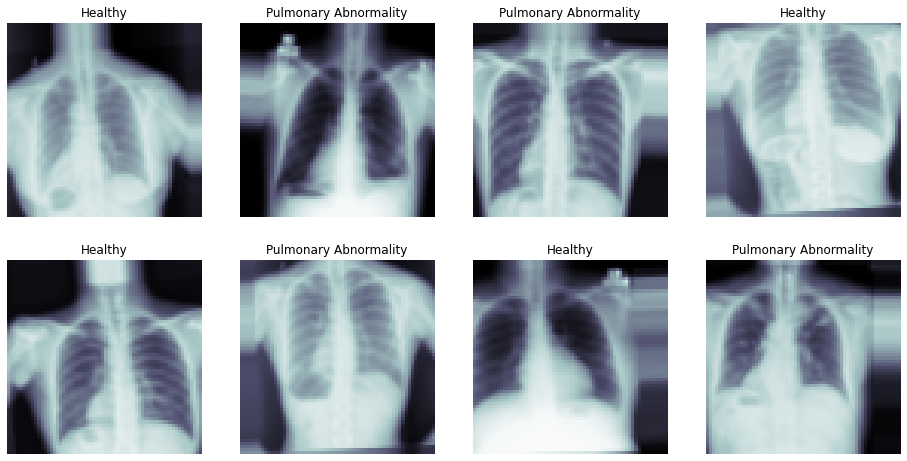

In [ ]:
import matplotlib.pyplot as plt

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = 0, vmax = 1)
    c_ax.set_title('%s' % ('Pulmonary Abnormality' if np.argmax(c_y)>0.5 else 'Healthy'))
    c_ax.axis('off')

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import *

img_shape = (IMG_SIZE, IMG_SIZE, 3)
inputs = Input(img_shape)
num_classes = 2

vgg16_model = VGG16(input_shape =  img_shape, include_top = False, weights = 'imagenet')
vgg16_model.trainable = False
outputs = vgg16_model(inputs)
outputs = BatchNormalization(name = 'BatchNormalization')(outputs)
outputs = GlobalAveragePooling2D()(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(256)(outputs)
outputs = LeakyReLU(alpha=0.1)(outputs)
outputs = Dropout(0.25)(outputs)
outputs = Dense(num_classes, activation = 'softmax')(outputs)

model = Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
BatchNormalization (BatchNor (None, 2, 2, 512)         2048      
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
______________________________________________________________

In [ ]:
!ls /content/onedrive

ls: cannot access '/content/onedrive': Transport endpoint is not connected


In [ ]:
from keras.callbacks import *

weight_path=os.path.join( 'onedrive//Fine Tuning with VGG16', '{}_pretrainedvgg16model.bestweights.hdf5'.format('TB'))
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, save_best_only=True, mode='auto', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="'val_acc'", mode="auto", patience=30) 

callbacks_list = [checkpoint, early, reduceLROnPlat]

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size
model.fit_generator(train_gen, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_gen, validation_steps=STEP_SIZE_VALID,
                    epochs = 10, callbacks = callbacks_list)
model.save('onedrive/xray-classification-tuberculosis/vgg16-x64')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
45/45 [==============================] - 377s 8s/step - loss: 0.6943 - accuracy: 0.6268 - val_loss: 0.9176 - val_accuracy: 0.3906
Epoch 2/10
45/45 [==============================] - 342s 8s/step - loss: 0.5759 - accuracy: 0.7222 - val_loss: 0.7031 - val_accuracy: 0.5312
Epoch 3/10
45/45 [==============================] - 349s 8s/step - loss: 0.5697 - accuracy: 0.7170 - val_loss: 0.6197 - val_accuracy: 0.6250
Epoch 4/10
45/45 [==============================] - 346s 8s/step - loss: 0.5636 - accuracy: 0.7476 - val_loss: 0.6275 - val_accuracy: 0.6719
Epoch 5/10
45/45 [==============================] - 348s 8s/step - loss: 0.6175 - accuracy: 0.7203 - val_loss: 0.5103 - val_accuracy: 0.7656
Epoch 6/10
45/45 [==============================] - 351s 8s/step - loss: 0.5942 - accuracy: 0.7320 - val_loss: 0.5851 - val_accuracy: 0.6562
Epoch 7/10
45/45 [==============================] - 351s 8s/step - loss: 0.5596 - accuracy: 0.7463 - val_loss: 0.5479 - val_accuracy: 0.7500
Epoch 8/10
45

In [ ]:
from keras.models import load_model

loaded = load_model('onedrive/xray-classification-tuberculosis/vgg16-x64')
loaded.fit_generator(train_gen, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_gen, validation_steps=STEP_SIZE_VALID,
                    epochs = 10)
loaded.save('onedrive/xray-classification-tuberculosis/vgg16-x64-20')

Measure accuracy on test data

In [ ]:
from keras.preprocessing import image_dataset_from_directory

results = model.evaluate_generator(valid_gen)
print("test loss, test acc:", results)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test loss, test acc: [0.6229875683784485, 0.6455696225166321]
